In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header = None)
test_df = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header = None)
# Value of each class
train_df[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

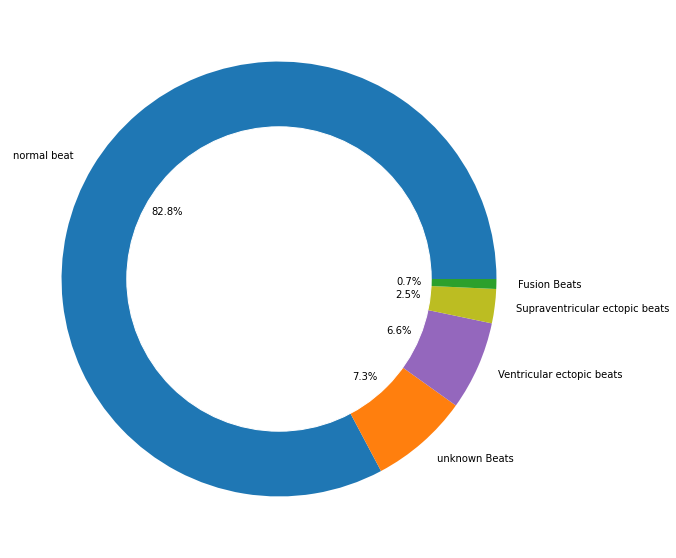

In [4]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [5]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

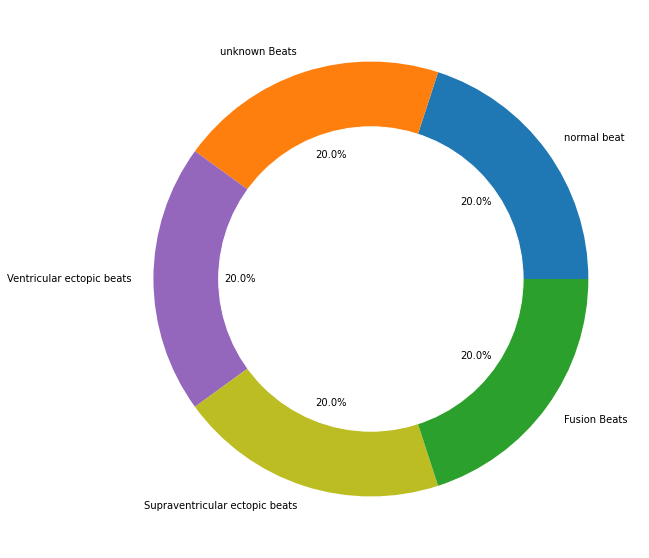

In [6]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [7]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
# peek on classes
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
55986,1.000000,0.895397,0.539749,0.100418,0.000000,0.150628,0.225941,0.238494,0.259414,0.276151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74507,0.995349,0.837209,0.200000,0.013953,0.097674,0.120930,0.069767,0.134884,0.200000,0.158140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
79131,0.000000,0.028381,0.091820,0.193656,0.250417,0.330551,0.382304,0.417362,0.479132,0.492487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80906,1.000000,0.949755,0.725490,0.443627,0.193627,0.131127,0.147059,0.109069,0.094363,0.087010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
85326,0.789389,0.702572,0.591640,0.454984,0.289389,0.168810,0.086817,0.054662,0.059486,0.090032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


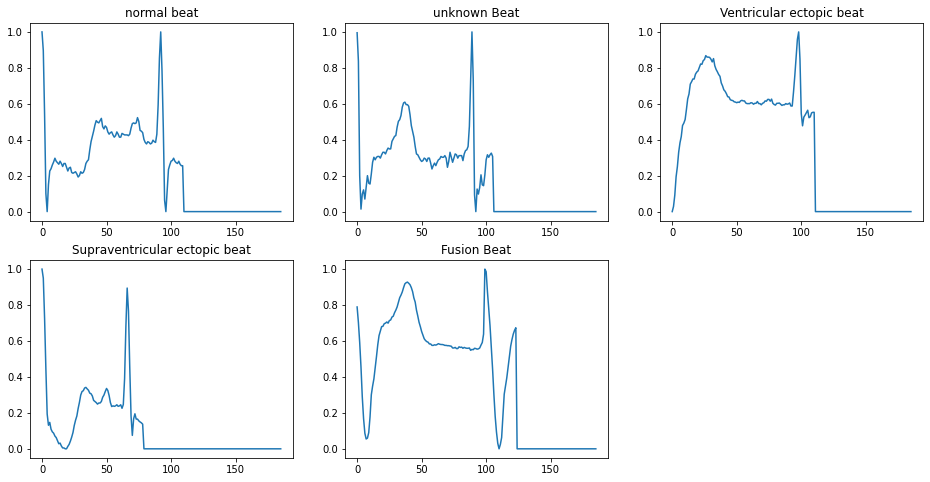

In [8]:
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)  
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)  
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)  
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()


In [9]:
def plot_hist(class_number,size,min_):
    # get the class data
    img=train_df.loc[train_df[187]==class_number].values
    # crop it
    img=img[:,min_:size]
    # creates a continous steam of data
    img_flatten=img.flatten()
    
    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()
# Normal Beat

1300000
1300000


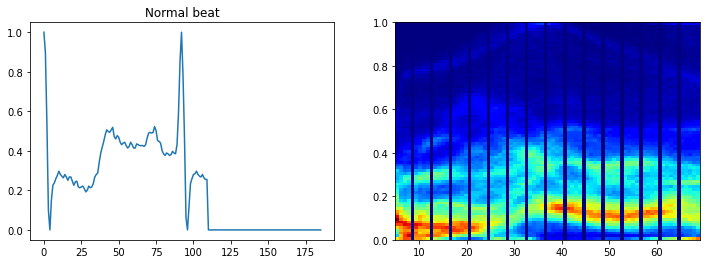

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)

900000
900000


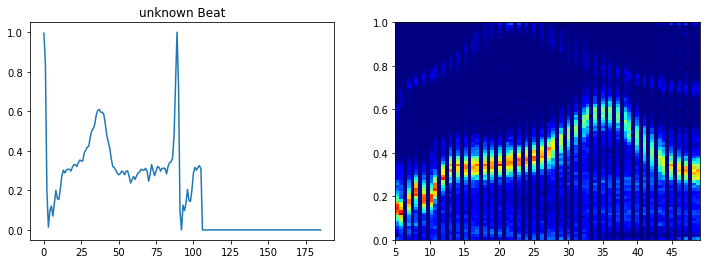

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
plt.subplot(1, 2, 2)  
plot_hist(1,50,5)

600000
600000


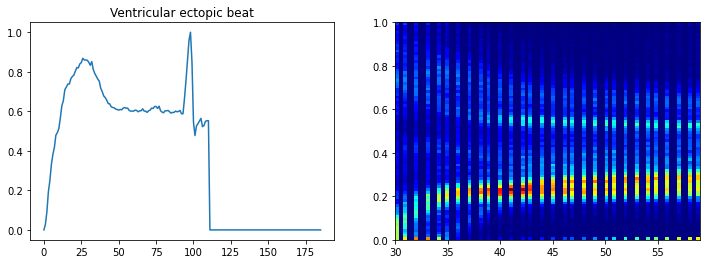

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(2,60,30)

700000
700000


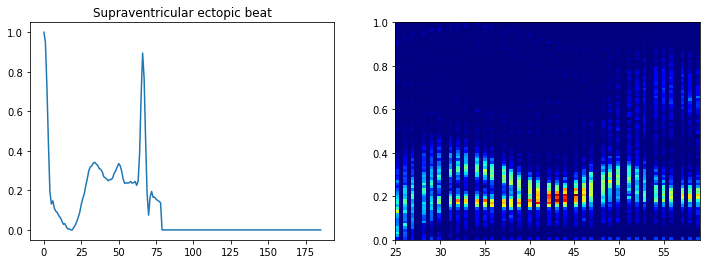

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1) 
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(3,60,25)

640000
640000


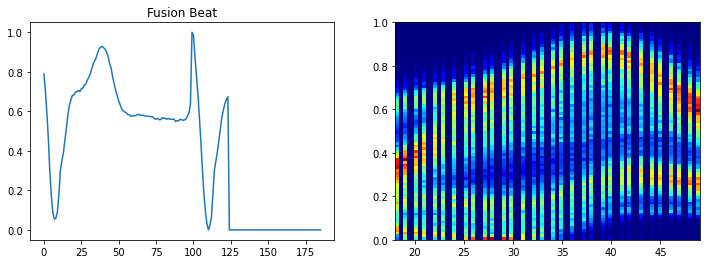

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)   
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
plt.subplot(1, 2, 2) 
plot_hist(4,50,18)

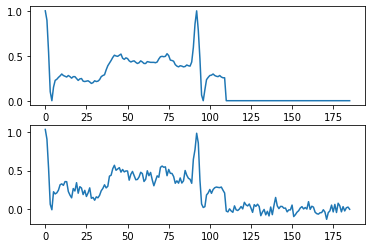

In [15]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)
tempo=classes.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()


In [16]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [17]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [18]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model

from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

2022-02-24 05:08:00.666989: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-24 05:08:01.020341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
3125/3125 [==============================] - 60s 19ms/step - loss: 0.1895 - accuracy: 0.9330 - val_loss: 0.1503 - val_accuracy: 0.9488
Epoch 2/5
3125/3125 [==============================] - 58s 19ms/step - loss: 0.0753 - accuracy: 0.9741 - val_loss: 0.1610 - val_accuracy: 0.9464
Epoch 3/5
3125/3125 [==============================] - 58s 19ms/step - loss: 0.0499 - accuracy: 0.9835 - val_loss: 0.1977 - val_accuracy: 0.9453
Epoch 4/5
3125/3125 [==============================] - 58s 19ms/step - loss: 0.0386 - accuracy: 0.9875 - val_loss: 0.1373 - val_accuracy: 0.9640
Epoch 5/5
3125/3125 [==============================] - 58s 19ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.1227 - val_accuracy: 0.9713


Accuracy: 97.13%


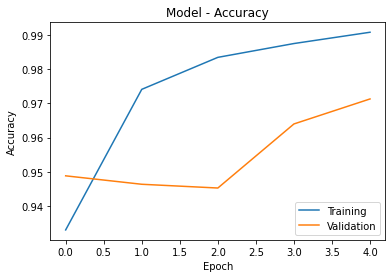

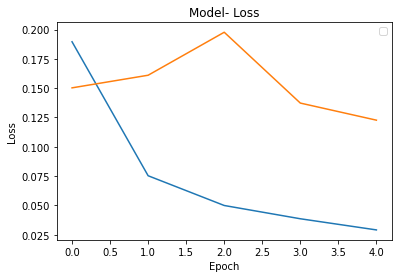

In [19]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test) 

Normalized confusion matrix


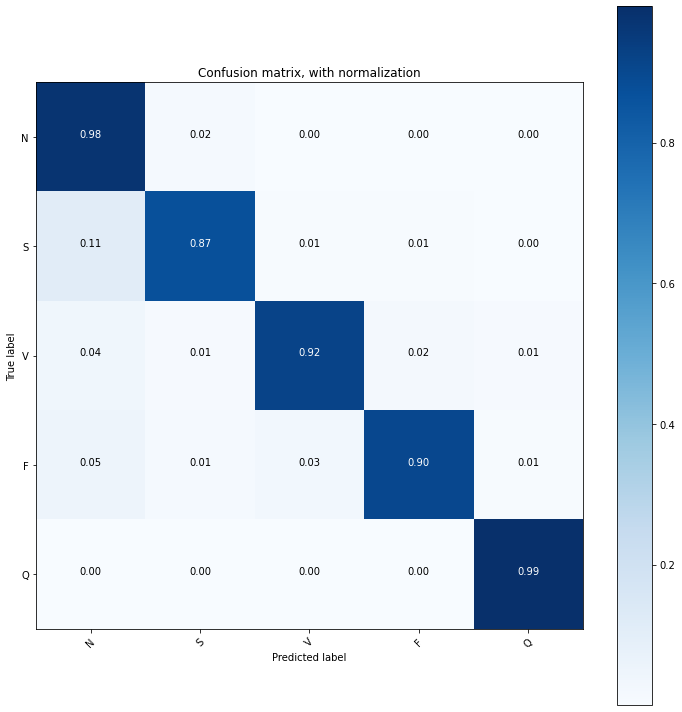

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()